In [1]:
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import struct
import pickle
import pandas as pd
import random

In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D

Using TensorFlow backend.


In [4]:
import sys
sys.path.append('../../src')

In [5]:
from pylab import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

In [6]:
from utils import FloatConvert32, FloatConvert64
from microssembly2 import Microssembly
from price_generator import random_walk, random_price
from simple_strategy import plot_trades

In [7]:
all_stocks = pd.read_csv('../../R_stock signal/allstocks.csv', index_col='Date')
all_stocks.index = pd.to_datetime(all_stocks.index)
symbols = np.unique(all_stocks.Company)
symbols.shape

(30,)

In [8]:
def get_price(symbol=None, days = 127):
    symbol = symbol if symbol else np.random.choice(symbols)
    data = all_stocks[all_stocks.Company == np.random.choice(symbols)]
    min_day, max_day = min(data.index), max(data.index)
    start_day = np.random.choice(pd.date_range(start=min_day, end=max_day, freq='D'))
    end_day = start_day + np.timedelta64(days, 'D')
    return data[start_day: end_day]

In [9]:
def get_strategy_signal(price):
    signal = pd.Series(index=price.index)
    signal[price.buy == 1] = 1
    signal[price.sell == 1] = 0
    signal

    return signal

In [10]:
def plot_signals(observed_signal, signal):
    df = pd.DataFrame({'true': observed_signal - 0.5, 'generated': signal - 0.5}, index=observed_signal.index)
    ax = df.plot.bar()
    my_xticks = ['Sell', 'Buy']
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(my_xticks)
    ax.set_xticklabels([])

In [11]:
def pad_left(series, n):
        head = series.index[0]
        pad_value = series[0]
        pad = pd.Series(np.full(n, pad_value), index=pd.date_range(start = head - pd.DateOffset(days=n-1),
                                                                   end = head) - pd.DateOffset(days=1))
        return pad.append(series)

In [12]:
def price_2_seq(price, window = 8):
    p = (price - price.shift(1)).fillna(0)
    p = pad_left(p, window - 1)
    return np.array([p.shift(-x).values[:window] for x in range(len(p) - (window - 1))[::]])

In [13]:
def features(price, window):
    f1 = np.expand_dims(price_2_seq(price.Open, window), axis=2)
    f2 = np.expand_dims(price_2_seq(price.Close, window), axis=2)
    f3 = np.expand_dims(price_2_seq(price.High, window), axis=2)
    f4 = np.expand_dims(price_2_seq(price.Low, window), axis=2)
    return np.concatenate([f1, f2, f3, f4], axis=2)

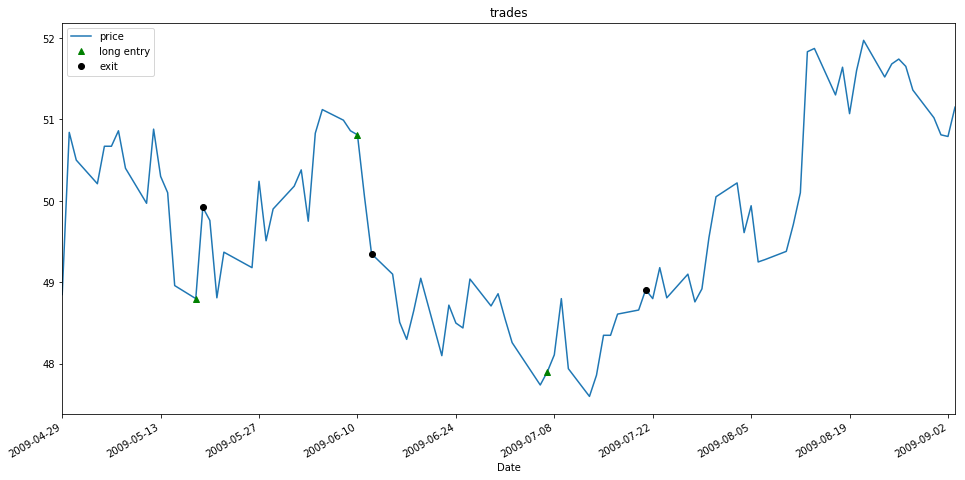

In [14]:
price = get_price()
signal = get_strategy_signal(price)
plot_trades(price.Open, signal, plt)

In [15]:
days = 2 * 365
seq_length = 60

In [16]:

price = get_price(symbol=symbols[0], days=days)
signal = get_strategy_signal(price)
for symbol in symbols[1:]:
    p = get_price(symbol=symbol, days=days)
    s = get_strategy_signal(p)
    price = price.append(p)
    signal = signal.append(s)
    
price.shape, signal.shape

((14571, 11), (14571,))

In [17]:
Y = to_categorical(signal.fillna(2).values)
X = features(price, window=seq_length)
test_cutoff = int(len(X) * 0.8)
x_train = X[:test_cutoff]
y_train = Y[:test_cutoff]
x_test = X[test_cutoff:]
y_test = Y[test_cutoff:]
buy_weight = int(len(signal[signal.isna()]) / len(signal[signal == 1]) / 2)
sell_weight = int(len(signal[signal.isna()]) / len(signal[signal == 0]) / 2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, buy_weight, sell_weight

((11656, 60, 4), (11656, 3), (2915, 60, 4), (2915, 3), 18, 18)

In [18]:
model = Sequential()
model.add(LSTM(16, input_shape=(seq_length, 4), return_sequences=True))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [19]:
model.fit(x_train, y_train,
              batch_size=32,
              epochs=500,
              validation_data=(x_test, y_test), class_weight={0:sell_weight, 1:buy_weight, 2:1})

Train on 11656 samples, validate on 2915 samples
Epoch 1/500
11656/11656 [==============================] - 46s 4ms/step - loss: 1.9085 - val_loss: 0.7654
Epoch 2/500
11656/11656 [==============================] - 44s 4ms/step - loss: 1.7309 - val_loss: 0.5827
Epoch 3/500
11656/11656 [==============================] - 44s 4ms/step - loss: 1.6340 - val_loss: 0.6049
Epoch 4/500
11656/11656 [==============================] - 44s 4ms/step - loss: 1.5557 - val_loss: 0.5795
Epoch 5/500
11656/11656 [==============================] - 44s 4ms/step - loss: 1.4853 - val_loss: 0.5961
Epoch 6/500
11656/11656 [==============================] - 44s 4ms/step - loss: 1.4227 - val_loss: 0.5209
Epoch 7/500
11656/11656 [==============================] - 44s 4ms/step - loss: 1.3308 - val_loss: 0.5975
Epoch 8/500
11656/11656 [==============================] - 44s 4ms/step - loss: 1.2826 - val_loss: 0.4480
Epoch 9/500
11656/11656 [==============================] - 44s 4ms/step - loss: 1.2240 - val_loss: 0.49

11656/11656 [==============================] - 43s 4ms/step - loss: 0.4673 - val_loss: 0.3030
Epoch 78/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.4890 - val_loss: 0.3269
Epoch 79/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.4934 - val_loss: 0.3337
Epoch 80/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.4970 - val_loss: 0.3415
Epoch 81/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.4541 - val_loss: 0.3786
Epoch 82/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.4587 - val_loss: 0.3116
Epoch 83/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.4709 - val_loss: 0.2861
Epoch 84/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.4511 - val_loss: 0.2939
Epoch 85/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.4623 - val_loss: 0.3561
Epoch 86/500
11656/11656 [========================

11656/11656 [==============================] - 43s 4ms/step - loss: 0.2946 - val_loss: 0.3147
Epoch 154/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2971 - val_loss: 0.3120
Epoch 155/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2922 - val_loss: 0.2973
Epoch 156/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.3042 - val_loss: 0.3028
Epoch 157/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2668 - val_loss: 0.3104
Epoch 158/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2646 - val_loss: 0.3309
Epoch 159/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2986 - val_loss: 0.3135
Epoch 160/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2985 - val_loss: 0.3056
Epoch 161/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2656 - val_loss: 0.2831
Epoch 162/500
11656/11656 [===============

Epoch 229/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1847 - val_loss: 0.2902
Epoch 230/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2001 - val_loss: 0.3668
Epoch 231/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2185 - val_loss: 0.3406
Epoch 232/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1962 - val_loss: 0.3210
Epoch 233/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1822 - val_loss: 0.3143
Epoch 234/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2020 - val_loss: 0.3058
Epoch 235/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1822 - val_loss: 0.3019
Epoch 236/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2083 - val_loss: 0.2904
Epoch 237/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.2048 - val_loss: 0.3372
Epoch 238/500
11656/11656 [=

Epoch 305/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1703 - val_loss: 0.3073
Epoch 306/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1707 - val_loss: 0.2845
Epoch 307/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1560 - val_loss: 0.3082
Epoch 308/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1525 - val_loss: 0.3197
Epoch 309/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1641 - val_loss: 0.2957
Epoch 310/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1542 - val_loss: 0.3369
Epoch 311/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1473 - val_loss: 0.2847
Epoch 312/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1579 - val_loss: 0.3318
Epoch 313/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1548 - val_loss: 0.3090
Epoch 314/500
11656/11656 [=

Epoch 381/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1198 - val_loss: 0.3509
Epoch 382/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1603 - val_loss: 0.3101
Epoch 383/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1180 - val_loss: 0.3248
Epoch 384/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1095 - val_loss: 0.3075
Epoch 385/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1713 - val_loss: 0.3064
Epoch 386/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1256 - val_loss: 0.3000
Epoch 387/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1161 - val_loss: 0.3213
Epoch 388/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1319 - val_loss: 0.3285
Epoch 389/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1360 - val_loss: 0.3204
Epoch 390/500
11656/11656 [=

Epoch 457/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.0951 - val_loss: 0.3169
Epoch 458/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1282 - val_loss: 0.3150
Epoch 459/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1407 - val_loss: 0.3263
Epoch 460/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1700 - val_loss: 0.3585
Epoch 461/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1034 - val_loss: 0.3400
Epoch 462/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.0925 - val_loss: 0.3434
Epoch 463/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1038 - val_loss: 0.3376
Epoch 464/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1235 - val_loss: 0.3310
Epoch 465/500
11656/11656 [==============================] - 43s 4ms/step - loss: 0.1217 - val_loss: 0.3386
Epoch 466/500
11656/11656 [=

In [24]:
price = get_price()
signal = get_strategy_signal(price)
f = features(price, window=seq_length)
predicted_signal = pd.Series(np.argmax(model.predict(f), axis=1), index=price.index).replace(2, np.nan)

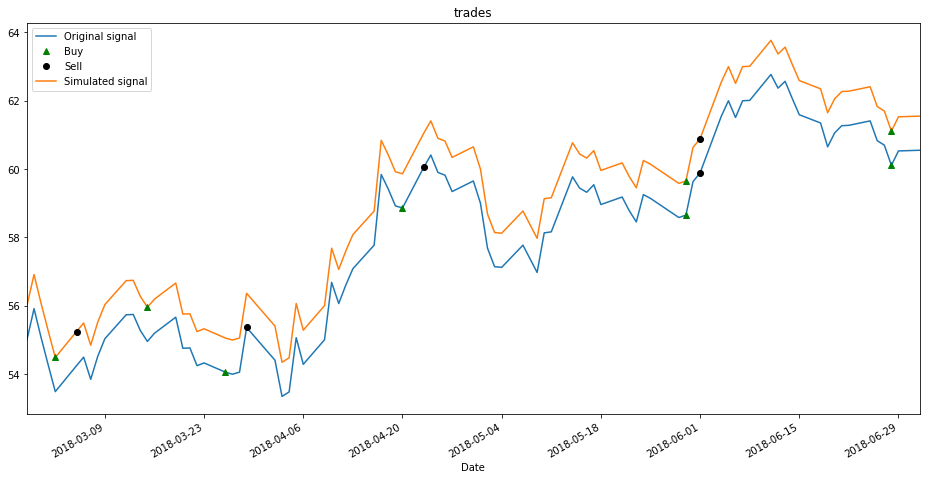

In [25]:
plot_trades(price.Open, signal, plt)
plot_trades(price.Open + 1, predicted_signal, plt)
plt.legend(['Original signal', 'Buy', 'Sell', 'Simulated signal'], loc='best')